In [2]:
import re
import base64


with open("dust_map_middl_eastt.html", "r", encoding="utf-8") as f:
    html = f.read()


match = re.search(r"data:image/png;base64,([A-Za-z0-9+/=]+)", html)

if not match:
    raise ValueError("No Base64 PNG found inside the HTML file.")

b64_str = match.group(1)


png_data = base64.b64decode(b64_str)

with open("dust_image_extracted.png", "wb") as f:
    f.write(png_data)

print(" Extracted image saved as dust_image_extracted.png")


 Extracted image saved as dust_image_extracted.png


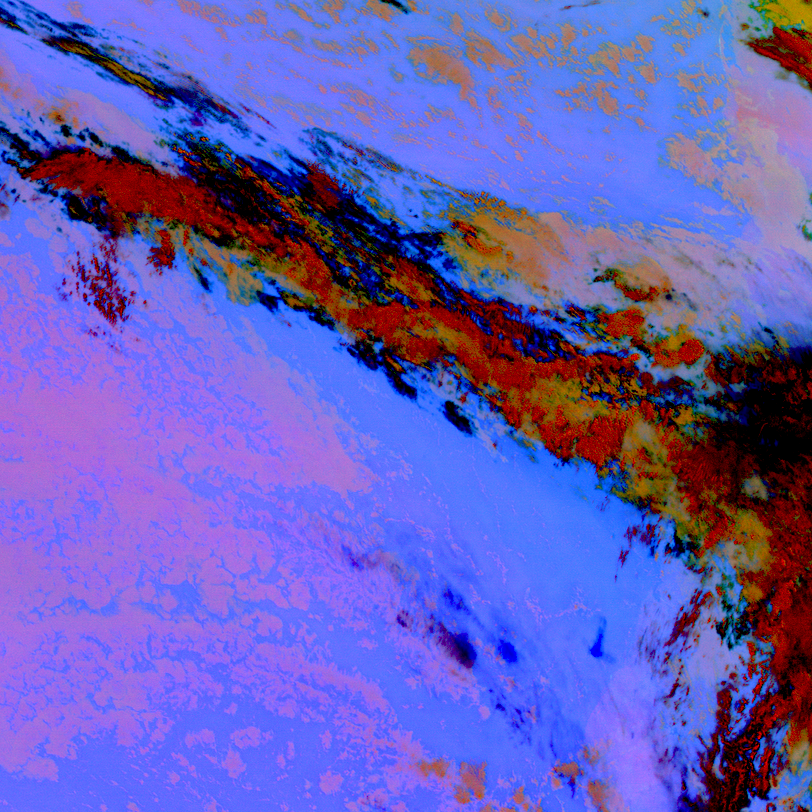

In [3]:
from IPython.display import Image, display
display(Image("dust_image_extracted.png"))


In [4]:
!pip install rasterio shapely pyproj pillow geojson

In [5]:
import rasterio
from rasterio.transform import from_bounds
import numpy as np
from PIL import Image


img = Image.open("dust_image_extracted.png").convert("RGB")
arr = np.array(img)


h, w, _ = arr.shape
h, w


(812, 812)

In [6]:
from rasterio.transform import from_bounds
import rasterio


left, bottom, right, top = 20, 10, 60, 40

transform = from_bounds(left, bottom, right, top, w, h)

with rasterio.open(
    "dust_geo.tif",
    "w",
    driver="GTiff",
    height=h,
    width=w,
    count=3,
    dtype=arr.dtype,
    crs="EPSG:4326",
    transform=transform,
) as dst:
    dst.write(arr[:,:,0], 1)
    dst.write(arr[:,:,1], 2)
    dst.write(arr[:,:,2], 3)

print("GeoTIFF created: dust_geo.tif")


GeoTIFF created: dust_geo.tif


In [7]:
import numpy as np
from skimage.color import rgb2hsv
from skimage.filters import threshold_otsu


hsv = rgb2hsv(arr)
hue = hsv[:,:,0]


thresh = threshold_otsu(hue)


dust_mask = hue < thresh

print("Mask created. Dust pixels:", np.sum(dust_mask))


Mask created. Dust pixels: 116258


In [9]:
import rasterio
from rasterio.features import shapes
import json
from shapely.geometry import shape, mapping
from shapely.ops import unary_union
from pyproj import Transformer


with rasterio.open("dust_geo.tif") as src:
    mask = dust_mask.astype(np.uint8)
    results = (
        (geom, val)
        for geom, val in shapes(mask, mask=mask, transform=src.transform)
        if val == 1
    )

    geoms = [shape(geom) for geom, _ in results]

print("Polygons extracted:", len(geoms))

# Merge all polygons into one multi-polygon
merged = unary_union(geoms)


transformer = Transformer.from_crs(src.crs, "EPSG:4326", always_xy=True)

def reproject_geom(geom):
    x, y = geom.exterior.coords.xy
    lon, lat = transformer.transform(x, y)
    return {
        "type": "Polygon",
        "coordinates": [list(zip(lon, lat))]
    }


if merged.geom_type == "Polygon":
    geojson_geom = reproject_geom(merged)
else:
    polys = []
    for part in merged.geoms:
        polys.append(reproject_geom(part))
    geojson_geom = {
        "type": "MultiPolygon",
        "coordinates": [p["coordinates"] for p in polys]
    }

# Save GeoJSON
geojson_data = {
    "type": "FeatureCollection",
    "features": [{
        "type": "Feature",
        "properties": {"name": "dust_region"},
        "geometry": geojson_geom
    }]
}

with open("dust_polygons.geojson", "w") as f:
    json.dump(geojson_data, f)

print("GeoJSON saved: dust_polygons.geojson")


Polygons extracted: 1173
GeoJSON saved: dust_polygons.geojson


In [11]:
from google.colab import files
files.download("dust_polygons.geojson")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [12]:
import folium
import json


geojson_path = "dust_polygons.geojson"


m = folium.Map(location=[25, 45], zoom_start=4)


folium.GeoJson(
    geojson_path,
    name="Dust Polygons",
    style_function=lambda x: {
        "fillColor": "yellow",
        "color": "red",
        "weight": 1,
        "fillOpacity": 0.4,
    },
).add_to(m)


folium.LayerControl().add_to(m)


m.save("dust_polygons_map.html")

"Map saved: dust_polygons_map.html"


'Map saved: dust_polygons_map.html'

In [14]:
from google.colab import files
files.download("dust_polygons_map.html")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>